In [1]:
# --- 1. Install necessary libraries ---
# (Run this cell once)
!pip install pandas openpyxl nltk matplotlib wordcloud scikit-learn
!pip install --upgrade Pillow==9.5.0
!pip install --upgrade scikit-learn
!pip install spacy

# --- 2. Import all required libraries ---
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, bigrams, trigrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- 3. One-time NLTK data downloads ---
# (This will download the necessary models and word lists)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('omw-1.4', quiet=True) # <-- ADD THIS LINE

print("✅ Libraries installed and imported successfully!")

✅ Libraries installed and imported successfully!


In [2]:
# --- 🔴 CONFIGURATION: PLEASE EDIT THESE TWO LINES 🔴 ---

# 1. FILE PATH:
# If you are on Windows, your path might look like: C:\Users\MyName\Documents\data.xlsx
# You MUST change it in one of two ways:
#   A) Add an 'r' before the string: r'C:\Users\MyName\Documents\data.xlsx'
#   B) Use forward slashes:         'C:/Users/MyName/Documents/data.xlsx'
#
EXCEL_FILE_PATH = r'D:/Z - Neverwonderland/2 - Prince Sarcawesum/1 - DESIGN\MEDIAWARE ARTS AND PRINTS/AAA_Corporate Material/Data Analysis/Verbatim Analysis/Dummy Verbatim Dataset.xlsx'  # 👈 CHANGE THIS

# 2. COLUMN NAME:
# This must be the *exact* name of the column in your Excel file that has the text.
#
TEXT_COLUMN_NAME = 'Verbatim'   # 👈 CHANGE THIS

# --- End Configuration ---


# --- Load Data (with dummy data as a fallback) ---
try:
    df = pd.read_excel(EXCEL_FILE_PATH)
    # Replaced f-string with .format() for older Python
    print("Successfully loaded data from '{}'".format(EXCEL_FILE_PATH))
    
except FileNotFoundError:
    # Replaced f-string and emoji
    print("Warning: File not found at '{}'.".format(EXCEL_FILE_PATH))
    print("Loading DUMMY DATA so you can still run the script.")
    df = pd.DataFrame({
        TEXT_COLUMN_NAME: [
            "The customer service was excellent! Very helpful and friendly.",
            "I'm very unhappy with the new update. It's slow and buggy.",
            "It's okay, but the price is too high for what you get.",
            "Love the new design! The user interface is so much better.",
            "Will recommend to all my friends. Keep up the great product development!",
            "The app crashes all thetime. Please fix this bug.",
            "Customer support didn't solve my problem and was rude.",
            "The delivery was fast, but the product was damaged.",
            "An average experience. Nothing special, but not bad either."
        ],
        'Rating': [5, 1, 3, 5, 5, 1, 2, 2, 3]
    })
except Exception as e:
    # Replaced f-string
    print("An error occurred: {}".format(e))
    print("Please check your file path and column name.")

# Ensure the text column exists and show a preview
if TEXT_COLUMN_NAME not in df.columns:
    # Replaced f-string and emoji
    print("Error: Column '{}' not found in the data.".format(TEXT_COLUMN_NAME))
    # Replaced f-string
    print("Available columns are: {}".format(df.columns.tolist()))
else:
    # Drop any rows where the verbatim column is empty
    df.dropna(subset=[TEXT_COLUMN_NAME], inplace=True)
    # Replaced f-string
    print("\nFound {} responses.".format(len(df)))
    print("\n--- Data Preview (First 5 Rows) ---")
    print(df.head())

Successfully loaded data from 'D:/Z - Neverwonderland/2 - Prince Sarcawesum/1 - DESIGN\MEDIAWARE ARTS AND PRINTS/AAA_Corporate Material/Data Analysis/Verbatim Analysis/Dummy Verbatim Dataset.xlsx'

Found 50 responses.

--- Data Preview (First 5 Rows) ---
   S.N.                                           Verbatim  Rating
0     1  "The website was a mess, couldn't find the spe...       2
1     2  "My new laptop overheated almost immediately a...       2
2     3  "I tried to use the live chat, but no one ever...       1
3     4  "The delivery was two days late and the box wa...       3
4     5  "I returned a broken phone and haven't receive...       2


In [3]:
# --- ADDED IMPORTS TO FIX NameError ---
# These imports make this cell self-contained
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# ---------------------------------------

# --- 1. Define custom stop words (optional) ---
# Add any words you want to ignore (e.g., your company or product name)
custom_stop_words = {'app', 'product', 'service', 'company'}
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# --- 2. Initialize the lemmatizer ---
# (Turns words into their root form: 'running' -> 'run')
lemmatizer = WordNetLemmatizer()

# --- 3. Define the cleaning function ---
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove leading/trailing whitespace
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2  # Remove stop words and short words
    ]
    
    return " ".join(cleaned_tokens)

# --- 4. Apply the cleaning function ---
# Make sure Cell 2 has been run at least once to create 'df'
df['cleaned_text'] = df[TEXT_COLUMN_NAME].apply(clean_text)

print("--- Data After Cleaning (Original vs. Cleaned) ---")
print(df[[TEXT_COLUMN_NAME, 'cleaned_text']].head())

--- Data After Cleaning (Original vs. Cleaned) ---
                                            Verbatim  \
0  "The website was a mess, couldn't find the spe...   
1  "My new laptop overheated almost immediately a...   
2  "I tried to use the live chat, but no one ever...   
3  "The delivery was two days late and the box wa...   
4  "I returned a broken phone and haven't receive...   

                                        cleaned_text  
0       website mess couldnt find spec tablet wanted  
1  new laptop overheated almost immediately turne...  
2  tried use live chat one ever responded whats p...  
3  delivery two day late box dented hope inside i...  
4  returned broken phone havent received refund y...  


--- Data with Sentiment Labels ---
                                            Verbatim sentiment_label
0  "The website was a mess, couldn't find the spe...        Negative
1  "My new laptop overheated almost immediately a...         Neutral
2  "I tried to use the live chat, but no one ever...        Negative
3  "The delivery was two days late and the box wa...        Positive
4  "I returned a broken phone and haven't receive...        Negative

--- Overall Sentiment Distribution ---


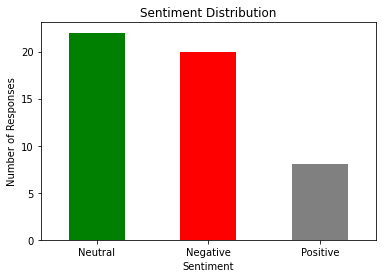

In [4]:
# --- 1. Initialize Sentiment Analyzer ---
sia = SentimentIntensityAnalyzer()

# --- 2. Get sentiment scores ---
# The 'compound' score is the most useful:
# > 0.05 is Positive
# < -0.05 is Negative
# between is Neutral
df['sentiment_compound'] = df[TEXT_COLUMN_NAME].apply(lambda x: sia.polarity_scores(x)['compound'])

# --- 3. Categorize sentiment ---
def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_compound'].apply(categorize_sentiment)

print("--- Data with Sentiment Labels ---")
print(df[[TEXT_COLUMN_NAME, 'sentiment_label']].head())

# --- 4. Plot the sentiment distribution ---
print("\n--- Overall Sentiment Distribution ---")
sentiment_counts = df['sentiment_label'].value_counts()
sentiment_counts.plot(kind='bar', 
                      title='Sentiment Distribution', 
                      color=['green', 'red', 'grey'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Responses')
plt.xticks(rotation=0)
plt.show()

--- Top 20 Most Common Words ---
[('new', 6), ('one', 6), ('never', 5), ('sent', 5), ('item', 5), ('couldnt', 4), ('sale', 4), ('arrived', 4), ('get', 4), ('store', 4), ('find', 3), ('laptop', 3), ('tried', 3), ('two', 3), ('phone', 3), ('help', 3), ('doesnt', 3), ('return', 3), ('order', 3), ('every', 3)]


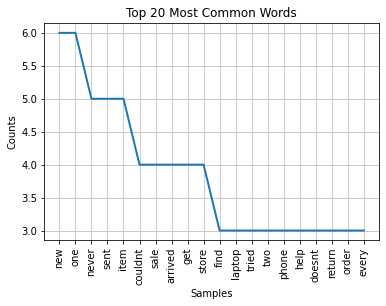


--- Top 10 Most Common 2-Word Phrases (Bigrams) ---
[(('item', 'stock'), 2), (('doesnt', 'work'), 2), (('website', 'mess'), 1), (('mess', 'couldnt'), 1), (('couldnt', 'find'), 1), (('find', 'spec'), 1), (('spec', 'tablet'), 1), (('tablet', 'wanted'), 1), (('wanted', 'new'), 1), (('new', 'laptop'), 1)]

--- Top 10 Most Common 3-Word Phrases (Trigrams) ---
[(('website', 'mess', 'couldnt'), 1), (('mess', 'couldnt', 'find'), 1), (('couldnt', 'find', 'spec'), 1), (('find', 'spec', 'tablet'), 1), (('spec', 'tablet', 'wanted'), 1), (('tablet', 'wanted', 'new'), 1), (('wanted', 'new', 'laptop'), 1), (('new', 'laptop', 'overheated'), 1), (('laptop', 'overheated', 'almost'), 1), (('overheated', 'almost', 'immediately'), 1)]


In [5]:
# --- 1. Combine all cleaned text into one big string ---
all_text = " ".join(df['cleaned_text'])
all_tokens = word_tokenize(all_text)

# --- 2. Most Common Words (Unigrams) ---
fdist = FreqDist(all_tokens)
print("--- Top 20 Most Common Words ---")
print(fdist.most_common(20))

# Plot the most common words
fdist.plot(20, title='Top 20 Most Common Words')
plt.show()

# --- 3. Most Common 2-Word Phrases (Bigrams) ---
print("\n--- Top 10 Most Common 2-Word Phrases (Bigrams) ---")
bgs = list(bigrams(all_tokens))
bigram_fdist = FreqDist(bgs)
print(bigram_fdist.most_common(10))

# --- 4. Most Common 3-Word Phrases (Trigrams) ---
print("\n--- Top 10 Most Common 3-Word Phrases (Trigrams) ---")
tgs = list(trigrams(all_tokens))
trigram_fdist = FreqDist(tgs)
print(trigram_fdist.most_common(10))

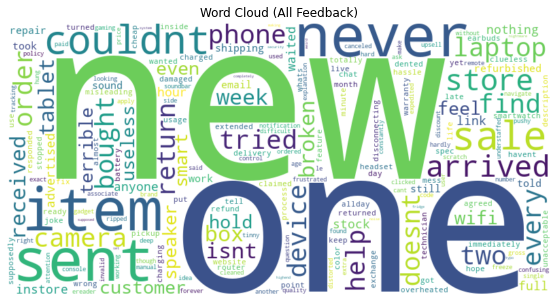

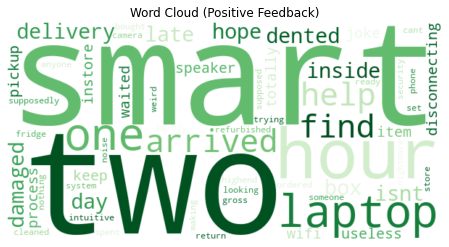

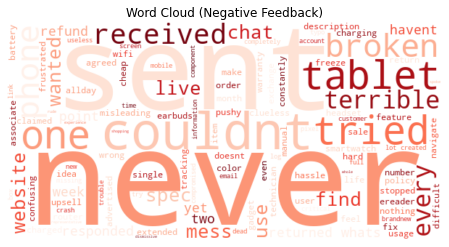

In [6]:
# --- 1. Generate Word Cloud for ALL Feedback ---
if all_text:
    wordcloud_all = WordCloud(width=800, 
                              height=400, 
                              background_color='white').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_all, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud (All Feedback)')
    plt.show()
else:
    print("No text to generate a word cloud.")

# --- 2. Generate Word Cloud for POSITIVE Feedback ---
positive_text = " ".join(df[df['sentiment_label'] == 'Positive']['cleaned_text'])
if positive_text:
    wordcloud_pos = WordCloud(width=600, 
                              height=300, 
                              colormap='Greens',
                              background_color='white').generate(positive_text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud (Positive Feedback)')
    plt.show()

# --- 3. Generate Word Cloud for NEGATIVE Feedback ---
negative_text = " ".join(df[df['sentiment_label'] == 'Negative']['cleaned_text'])
if negative_text:
    wordcloud_neg = WordCloud(width=600, 
                              height=300, 
                              colormap='Reds',
                              background_color='white').generate(negative_text)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud (Negative Feedback)')
    plt.show()

In [7]:
# --- 1. Create a Document-Term Matrix (DTM) ---
# This counts how many times each word appears in each response
vectorizer = CountVectorizer(max_df=0.9,  # Ignore words in > 90% of docs
                             min_df=2,  # Ignore words in < 2 docs
                             stop_words='english')

# Only run if we have enough data
if len(df['cleaned_text']) > 1:
    dtm = vectorizer.fit_transform(df['cleaned_text'])

    # --- 2. 🔴 CONFIGURATION: Choose number of topics ---
    NUMBER_OF_TOPICS = 3  # 👈 TRY CHANGING THIS (e.g., 3, 5, 8)

    # --- 3. Build the LDA model ---
    lda = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=42)
    lda.fit(dtm)

    # --- 4. Display the topics ---
    print(f"\n--- Discovered {NUMBER_OF_TOPICS} Topics ---")
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(lda.components_):
        # Get the top 10 words for this topic
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

else:
    print("Not enough data to perform topic modeling (need at least 2 responses).")

print("\n--- Analysis Complete ---")


--- Discovered 3 Topics ---
Topic #1: item, store, new, camera, hour, useless, broken, stock, waited, smart
Topic #2: sent, sale, doesnt, bought, new, return, work, shipping, sound, terrible
Topic #3: arrived, device, laptop, tried, order, help, isnt, customer, box, tablet

--- Analysis Complete ---


In [8]:
# --- 1. CONFIGURATION ---
N_WORDS = 20
N_BIGRAMS = 10
N_TRIGRAMS = 10

# --- 2. Separate text and tokens by sentiment ---
positive_text = " ".join(df[df['sentiment_label'] == 'Positive']['cleaned_text'])
negative_text = " ".join(df[df['sentiment_label'] == 'Negative']['cleaned_text'])
neutral_text = " ".join(df[df['sentiment_label'] == 'Neutral']['cleaned_text'])

positive_tokens = word_tokenize(positive_text)
negative_tokens = word_tokenize(negative_text)
neutral_tokens = word_tokenize(neutral_text)

# --- 3. Get the most common UNIGRAMS (words) for each sentiment ---
top_pos_words = [word for word, freq in FreqDist(positive_tokens).most_common(N_WORDS)]
top_neg_words = [word for word, freq in FreqDist(negative_tokens).most_common(N_WORDS)]
top_neu_words = [word for word, freq in FreqDist(neutral_tokens).most_common(N_WORDS)]

# --- 4. Get the most common BIGRAMS for each sentiment ---
top_pos_bigrams = [bigram for bigram, freq in FreqDist(list(bigrams(positive_tokens))).most_common(N_BIGRAMS)]
top_neg_bigrams = [bigram for bigram, freq in FreqDist(list(bigrams(negative_tokens))).most_common(N_BIGRAMS)]
top_neu_bigrams = [bigram for bigram, freq in FreqDist(list(bigrams(neutral_tokens))).most_common(N_BIGRAMS)]

# --- 5. Get the most common TRIGRAMS for each sentiment ---
top_pos_trigrams = [trigram for trigram, freq in FreqDist(list(trigrams(positive_tokens))).most_common(N_TRIGRAMS)]
top_neg_trigrams = [trigram for trigram, freq in FreqDist(list(trigrams(negative_tokens))).most_common(N_TRIGRAMS)]
top_neu_trigrams = [trigram for trigram, freq in FreqDist(list(trigrams(neutral_tokens))).most_common(N_TRIGRAMS)]

print(f"✅ Prepared top {N_WORDS} words, {N_BIGRAMS} bigrams, and {N_TRIGRAMS} trigrams for each sentiment.")
print(f"\nExample: Top {N_WORDS} Positive Words:\n", top_pos_words)

✅ Prepared top 20 words, 10 bigrams, and 10 trigrams for each sentiment.

Example: Top 20 Positive Words:
 ['two', 'smart', 'hour', 'laptop', 'one', 'arrived', 'help', 'find', 'delivery', 'day', 'late', 'box', 'dented', 'hope', 'inside', 'isnt', 'damaged', 'speaker', 'keep', 'disconnecting']


In [9]:
def jaccard_similarity(list1, list2):
    """Calculates the Jaccard similarity between two lists."""
    set1 = set(list1)
    set2 = set(list2)
    
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    # Avoid division by zero
    if not union:
        return 0.0
        
    return len(intersection) / len(union)

# --- Calculate similarities for all pairs ---
comparisons = {
    "Comparison": ["Positive vs. Negative", "Positive vs. Neutral", "Negative vs. Neutral"],
    f"Words (Top {N_WORDS})": [
        jaccard_similarity(top_pos_words, top_neg_words),
        jaccard_similarity(top_pos_words, top_neu_words),
        jaccard_similarity(top_neg_words, top_neu_words)
    ],
    f"Bigrams (Top {N_BIGRAMS})": [
        jaccard_similarity(top_pos_bigrams, top_neg_bigrams),
        jaccard_similarity(top_pos_bigrams, top_neu_bigrams),
        jaccard_similarity(top_neg_bigrams, top_neu_bigrams)
    ],
    f"Trigrams (Top {N_TRIGRAMS})": [
        jaccard_similarity(top_pos_trigrams, top_neg_trigrams),
        jaccard_similarity(top_pos_trigrams, top_neu_trigrams),
        jaccard_similarity(top_neg_trigrams, top_neu_trigrams)
    ]
}

# --- Display results in a DataFrame ---
similarity_df = pd.DataFrame(comparisons)
print("--- Jaccard Similarity Scores ---")
print("(A score of 1.0 means identical vocabulary; 0.0 means no overlap.)")
display(similarity_df.round(3))

--- Jaccard Similarity Scores ---
(A score of 1.0 means identical vocabulary; 0.0 means no overlap.)


,Comparison,Words (Top 20),Bigrams (Top 10),Trigrams (Top 10)
0,Positive vs. Negative,0.053,0.0,0.0
1,Positive vs. Neutral,0.053,0.0,0.0
2,Negative vs. Neutral,0.053,0.0,0.0


In [14]:
# --- 1. Install spaCy and its English model ---
# This model includes the word vectors we need for semantic similarity.
!pip install spacy
!python -m spacy download en_core_web_md

# --- 2. Load the spaCy model ---
try:
    nlp = spacy.load("en_core_web_md")
    print("spaCy model 'en_core_web_md' loaded successfully.")
except OSError:
    print("spaCy model not found. Please re-run the cell above to download it.")
    nlp = None

# --- 3. Prepare overall top words and phrases ---
N_WORDS = 10
N_BIGRAMS = 10
N_TRIGRAMS = 10

# Combine all cleaned text into one list of tokens
all_tokens = word_tokenize(" ".join(df['cleaned_text']))

# Get the overall most common items
top_words_overall = [word for word, freq in FreqDist(all_tokens).most_common(N_WORDS)]
top_bigrams_overall = [bigram for bigram, freq in FreqDist(list(bigrams(all_tokens))).most_common(N_BIGRAMS)]
top_trigrams_overall = [trigram for trigram, freq in FreqDist(list(trigrams(all_tokens))).most_common(N_TRIGRAMS)]

print(f"\n✅ Prepared top {N_WORDS} words, {N_BIGRAMS} bigrams, and {N_TRIGRAMS} trigrams from the entire dataset.")

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
spaCy model 'en_core_web_md' loaded successfully.

✅ Prepared top 10 words, 10 bigrams, and 10 trigrams from the entire dataset.


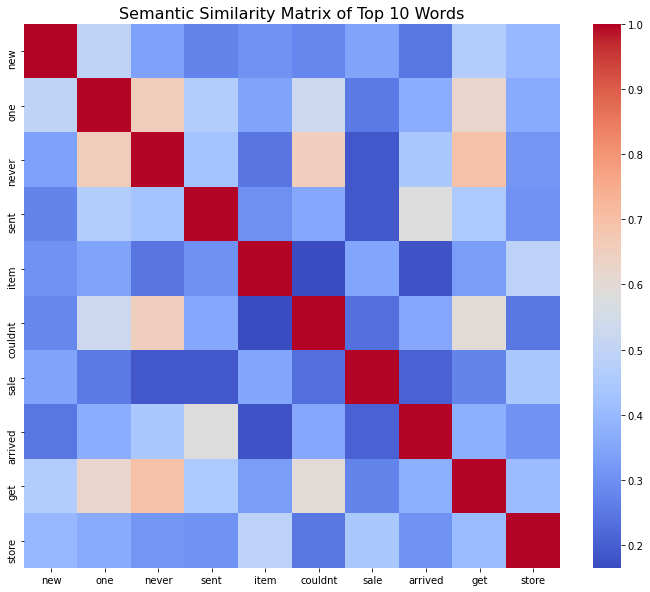

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

if nlp:
    # --- 1. Calculate the pairwise similarity matrix ---
    # Get the spaCy vector for each word
    word_vectors = [nlp(word).vector for word in top_words_overall]
    
    # Initialize an empty matrix
    similarity_matrix = np.zeros((len(word_vectors), len(word_vectors)))
    
    # Use spaCy's built-in fast similarity calculation
    for i in range(len(word_vectors)):
        for j in range(len(word_vectors)):
            # spaCy vectors need to be reshaped for this calculation
            similarity_matrix[i, j] = np.dot(word_vectors[i], word_vectors[j]) / (np.linalg.norm(word_vectors[i]) * np.linalg.norm(word_vectors[j]))

    # --- 2. Create a DataFrame for the heatmap ---
    similarity_df_words = pd.DataFrame(similarity_matrix, index=top_words_overall, columns=top_words_overall)

    # --- 3. Plot the heatmap ---
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_df_words, cmap='coolwarm')
    plt.title(f'Semantic Similarity Matrix of Top {N_WORDS} Words', fontsize=16)
    plt.show()
else:
    print("spaCy model not loaded. Please complete the setup in the previous cell.")

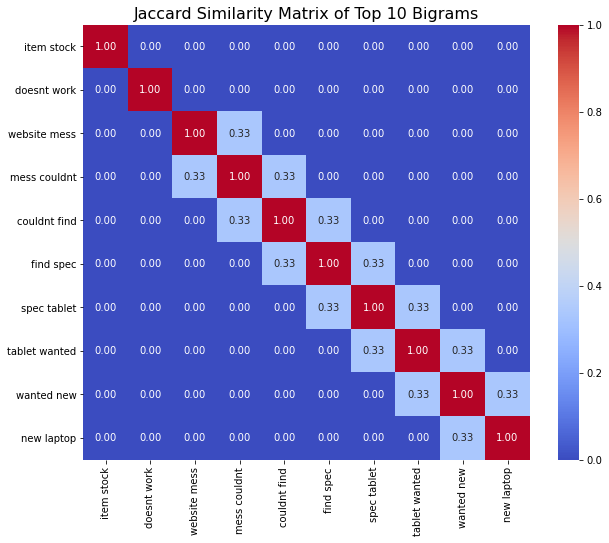

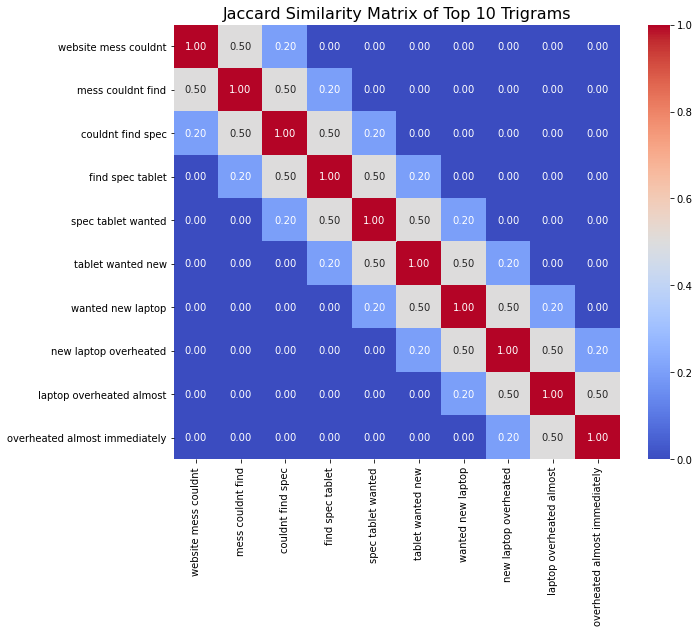

In [12]:
# (This uses the jaccard_similarity function defined in a previous cell)

# --- 1. Bigram Similarity ---
bigram_matrix = np.zeros((N_BIGRAMS, N_BIGRAMS))
for i, bigram1 in enumerate(top_bigrams_overall):
    for j, bigram2 in enumerate(top_bigrams_overall):
        # We compare the sets of words within each bigram
        bigram_matrix[i, j] = jaccard_similarity(list(bigram1), list(bigram2))

# Create string labels for the plot
bigram_labels = [' '.join(bigram) for bigram in top_bigrams_overall]
similarity_df_bigrams = pd.DataFrame(bigram_matrix, index=bigram_labels, columns=bigram_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df_bigrams, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Jaccard Similarity Matrix of Top {N_BIGRAMS} Bigrams', fontsize=16)
plt.show()

# --- 2. Trigram Similarity ---
trigram_matrix = np.zeros((N_TRIGRAMS, N_TRIGRAMS))
for i, trigram1 in enumerate(top_trigrams_overall):
    for j, trigram2 in enumerate(top_trigrams_overall):
        trigram_matrix[i, j] = jaccard_similarity(list(trigram1), list(trigram2))

# Create string labels for the plot
trigram_labels = [' '.join(trigram) for trigram in top_trigrams_overall]
similarity_df_trigrams = pd.DataFrame(trigram_matrix, index=trigram_labels, columns=trigram_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df_trigrams, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Jaccard Similarity Matrix of Top {N_TRIGRAMS} Trigrams', fontsize=16)
plt.show()